## Introduction

In this project, we will analyze the spread of the new corona virus (nCov). We will use two datasets:
    - The John Hopkins University's dataset which contains aggregated daily data for confirmed cases, deaths and recovered patients. 
    https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
    - The DXY.cn's google sheet which contains information of about 1000 patients. 
    https://docs.google.com/spreadsheets/d/1jS24DjSPVWa4iuxuD4OAXrE3QeI8c9BC1hSlqr-NMiU/edit#gid=1187587451


Son Huynh
29.02.2020

About getting dataset:

The reddit's datasets group is a good place to look for datasets. For example, you can check out useful sources for nCov data from here: https://www.reddit.com/r/datasets/comments/exnzrd/coronavirus_datasets/

Reddit in general is great for getting tips and browsing discussions. Some of my favorite subreddits are dataisbeautiful, datascience, MachineLearning.


In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas

In [4]:
url_case = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_cured = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

Let's take a look at the case time series first

In [5]:
case = pd.read_csv(url_case, index_col=[0, 1, 2, 3])
cured = pd.read_csv(url_cured, index_col=[0, 1, 2, 3])
deaths = pd.read_csv(url_death, index_col=[0, 1, 2, 3])

case.head()


1/22/20  1/23/20  1/24/20  \
Province/State Country/Region Lat     Long                                  
NaN            Thailand       15.0000 101.0000        2        3        5   
               Japan          36.0000 138.0000        2        1        2   
               Singapore      1.2833  103.8333        0        1        3   
               Nepal          28.1667 84.2500         0        0        0   
               Malaysia       2.5000  112.5000        0        0        0   

                                                1/25/20  1/26/20  1/27/20  \
Province/State Country/Region Lat     Long                                  
NaN            Thailand       15.0000 101.0000        7        8        8   
               Japan          36.0000 138.0000        2        4        4   
               Singapore      1.2833  103.8333        3        4        5   
               Nepal          28.1667 84.2500         1        1        1   
               Malaysia       2.5000  112.5000        3        4        4   

                                                1/28/20  1/29/20  1/30/20  \
Province/State Country/Region Lat     Long                                  
NaN            Thailand       15.0000 101.0000       14       14       14   
               Japan          36.0000 138.0000        7        7       11   
               Singapore      1.2833  103.8333        7        7       10   
               Nepal          28.1667 84.2500         1        1        1   
               Malaysia       2.5000  112.5000        4        7        8   

                                                1/31/20  ...  3/2/20  3/3/20  \
Province/State Country/Region Lat     Long               ...                   
NaN            Thailand       15.0000 101.0000       19  ...      43      43   
               Japan          36.0000 138.0000       15  ...     274     293   
               Singapore      1.2833  103.8333       13  ...     108     110   
               Nepal          28.1667 84.2500         1  ...       1       1   
               Malaysia       2.5000  112.5000        8  ...      29      36   

                                                3/4/20  3/5/20  3/6/20  \
Province/State Country/Region Lat     Long                               
NaN            Thailand       15.0000 101.0000      43      47      48   
               Japan          36.0000 138.0000     331     360     420   
               Singapore      1.2833  103.8333     110     117     130   
               Nepal          28.1667 84.2500        1       1       1   
               Malaysia       2.5000  112.5000      50      50      83   

                                                3/7/20  3/8/20  3/9/20  \
Province/State Country/Region Lat     Long                               
NaN            Thailand       15.0000 101.0000      50      50      50   
               Japan          36.0000 138.0000     461     502     511   
               Singapore      1.2833  103.8333     138     150     150   
               Nepal          28.1667 84.2500        1       1       1   
               Malaysia       2.5000  112.5000      93      99     117   

                                                3/10/20  3/11/20  
Province/State Country/Region Lat     Long                        
NaN            Thailand       15.0000 101.0000       53       59  
               Japan          36.0000 138.0000      581      639  
               Singapore      1.2833  103.8333      160      178  
               Nepal          28.1667 84.2500         1        1  
               Malaysia       2.5000  112.5000      129      149  

[5 rows x 50 columns]

Since the John Hopkins dataset contains only aggregated data, we need to transform it into a format that allows us to answer more questions. You can see the ideal dataframe structure in the picture below.

You will need to:
- Stack the dataframe so that each row represents one date in a location. 
- Remove the rows where the cumulative number of cases is zero.
- Make a new column `location` to combine `prov_state` and `country`.
- Make a new column `new_case` to derive the new case number from cumulative case number.
- Convert the date column to datetime object.

After transforming data for number of cases, you can do the same for number of deaths and cureds (or write a function to transform 3 datasets). Then you can use `pd.merge()` to merge them into one dataframe. Hint: try merging `case` with `death` first and then merge that with `cured`. You should use a `left` merge on `['location', 'prov_state', 'country', 'lat', 'long', 'date']` columns

![title](desired_format.png)

In [6]:
# stack to represent a location per row
stack = case.stack()
stack = stack.reset_index()

# rename columns
stack.columns = ['ProvinceState','CountryRegion', 'Lat', 'Long','date','cum_cases']

# remove rows where cummulative cases are 0
stack = stack[stack.cum_cases!=0]

# create a location column combining ProviceState or CountryRegion
stack['location'] = np.where(stack.ProvinceState.notna(), stack.ProvinceState, stack.CountryRegion)

# create a new cases column
# stack['new_cases'] = np.where(stack.cum_cases.diff(periods=1)>=0, stack.cum_cases.diff(periods=1), stack.cum_cases)
stack['new_cases'] = stack.groupby('location').cum_cases.diff(1)
stack.new_cases = stack.new_cases.fillna(stack.cum_cases)

# convert the date column to datetime object
stack.date = pd.to_datetime(stack.date, format='%m/%d/%y', errors='coerce')

# rearranging the columns and assigning to dataframe variable.
df = stack[['location', 'ProvinceState', 'CountryRegion', 'Lat', 'Long', 'date', 'cum_cases', 'new_cases']]

df.iloc[1505:1550]

,location,ProvinceState,CountryRegion,Lat,Long,date,cum_cases,new_cases
3096,Andorra,NaN,Andorra,42.5063,1.5218,2020-03-08,1,0.0
3097,Andorra,NaN,Andorra,42.5063,1.5218,2020-03-09,1,0.0
3098,Andorra,NaN,Andorra,42.5063,1.5218,2020-03-10,1,0.0
3099,Andorra,NaN,Andorra,42.5063,1.5218,2020-03-11,1,0.0
3140,Tasmania,Tasmania,Australia,-41.4545,145.9707,2020-03-02,1,1.0
3141,Tasmania,Tasmania,Australia,-41.4545,145.9707,2020-03-03,1,0.0
3142,Tasmania,Tasmania,Australia,-41.4545,145.9707,2020-03-04,1,0.0
3143,Tasmania,Tasmania,Australia,-41.4545,145.9707,2020-03-05,1,0.0
3144,Tasmania,Tasmania,Australia,-41.4545,145.9707,2020-03-06,1,0.0
3145,Tasmania,Tasmania,Australia,-41.4545,145.9707,2020-03-07,1,0.0


In [7]:
# data for cured and deaths are arranged in the same manner as cases
cured.head()

1/22/20  1/23/20  1/24/20  \
Province/State Country/Region Lat     Long                                  
NaN            Thailand       15.0000 101.0000        0        0        0   
               Japan          36.0000 138.0000        0        0        0   
               Singapore      1.2833  103.8333        0        0        0   
               Nepal          28.1667 84.2500         0        0        0   
               Malaysia       2.5000  112.5000        0        0        0   

                                                1/25/20  1/26/20  1/27/20  \
Province/State Country/Region Lat     Long                                  
NaN            Thailand       15.0000 101.0000        0        2        2   
               Japan          36.0000 138.0000        0        1        1   
               Singapore      1.2833  103.8333        0        0        0   
               Nepal          28.1667 84.2500         0        0        0   
               Malaysia       2.5000  112.5000        0        0        0   

                                                1/28/20  1/29/20  1/30/20  \
Province/State Country/Region Lat     Long                                  
NaN            Thailand       15.0000 101.0000        5        5        5   
               Japan          36.0000 138.0000        1        1        1   
               Singapore      1.2833  103.8333        0        0        0   
               Nepal          28.1667 84.2500         0        0        0   
               Malaysia       2.5000  112.5000        0        0        0   

                                                1/31/20  ...  3/2/20  3/3/20  \
Province/State Country/Region Lat     Long               ...                   
NaN            Thailand       15.0000 101.0000        5  ...      31      31   
               Japan          36.0000 138.0000        1  ...      32      43   
               Singapore      1.2833  103.8333        0  ...      78      78   
               Nepal          28.1667 84.2500         0  ...       1       1   
               Malaysia       2.5000  112.5000        0  ...      18      22   

                                                3/4/20  3/5/20  3/6/20  \
Province/State Country/Region Lat     Long                               
NaN            Thailand       15.0000 101.0000      31      31      31   
               Japan          36.0000 138.0000      43      43      46   
               Singapore      1.2833  103.8333      78      78      78   
               Nepal          28.1667 84.2500        1       1       1   
               Malaysia       2.5000  112.5000      22      22      22   

                                                3/7/20  3/8/20  3/9/20  \
Province/State Country/Region Lat     Long                               
NaN            Thailand       15.0000 101.0000      31      31      31   
               Japan          36.0000 138.0000      76      76      76   
               Singapore      1.2833  103.8333      78      78      78   
               Nepal          28.1667 84.2500        1       1       1   
               Malaysia       2.5000  112.5000      23      24      24   

                                                3/10/20  3/11/20  
Province/State Country/Region Lat     Long                        
NaN            Thailand       15.0000 101.0000       33       34  
               Japan          36.0000 138.0000      101      118  
               Singapore      1.2833  103.8333       78       96  
               Nepal          28.1667 84.2500         1        1  
               Malaysia       2.5000  112.5000       24       26  

[5 rows x 50 columns]

In [8]:
stack = deaths.stack()
stack = stack.reset_index()

# rename columns
stack.columns = ['ProvinceState','CountryRegion', 'Lat', 'Long','date','cum_deaths']
# stack = stack[stack.cum_deaths>0]

# create a location column combining ProviceState or CountryRegion
stack['location'] = np.where(stack.ProvinceState.notna(), stack.ProvinceState, stack.CountryRegion)

# create a new deaths column
# stack['new_deaths'] = np.where(stack.cum_deaths.diff(periods=1)>=0, stack.cum_deaths.diff(periods=1), stack.cum_deaths)
stack['new_deaths'] = stack.groupby('location').cum_deaths.diff(1)
stack.new_deaths = stack.new_deaths.fillna(stack.cum_deaths)

# convert the date column to datetime object
stack.date = pd.to_datetime(stack.date, format='%m/%d/%y', errors='coerce')

# rearrange dataframe.
stack = stack[['location', 'ProvinceState', 'CountryRegion', 'Lat', 'Long', 'date', 'cum_deaths', 'new_deaths']]

# merge deaths with cases
df = df.merge(stack)
df.head(20)
df[df.new_deaths<0]

,location,ProvinceState,CountryRegion,Lat,Long,date,cum_cases,new_cases,cum_deaths,new_deaths


In [9]:
stack = cured.stack()
stack = stack.reset_index()

# rename columns
stack.columns = ['ProvinceState','CountryRegion', 'Lat', 'Long','date','cum_cured']

# create a location column combining ProviceState or CountryRegion
stack['location'] = np.where(stack.ProvinceState.notna(), stack.ProvinceState, stack.CountryRegion)

# create a new cases column
# stack['new_cured'] = np.where(stack.cum_cured.diff(periods=1)>=0, stack.cum_cured.diff(periods=1), stack.cum_cured)
stack['new_cured'] = stack.groupby('location').cum_cured.diff(1)
stack.new_cured = stack.new_cured.fillna(stack.cum_cured)

# convert the date column to datetime object
stack.date = pd.to_datetime(stack.date, format='%m/%d/%y', errors='coerce')

# rearrange dataframe.
stack = stack[['location', 'ProvinceState', 'CountryRegion', 'Lat', 'Long', 'date', 'cum_cured', 'new_cured']]

# merge cured with cases
df = df.merge(stack)


In [10]:
df.groupby(df.location=='US')['cum_cases']

In [11]:
# selected countries in different regions
countries_benelux = ['Belgium', 'Netherlands', 'Luxembourg']
countries_northEU = ['Denmark','Iceland', 'Finland', 'Norway', 'Sweden']
countries_southEU = ['Greece', 'Italy', 'Malta', 'Portugal', 'Spain']
countries_northAmerica = ['US', 'Canada', 'Mexico']

# N countries with most cases:
N = 10

countries = df.groupby('CountryRegion').new_cases.sum().sort_values(ascending = False).head(N)
most_infected = countries.index.tolist()[:]
start_date = pd.to_datetime('01/15/20', format='%m/%d/%y')

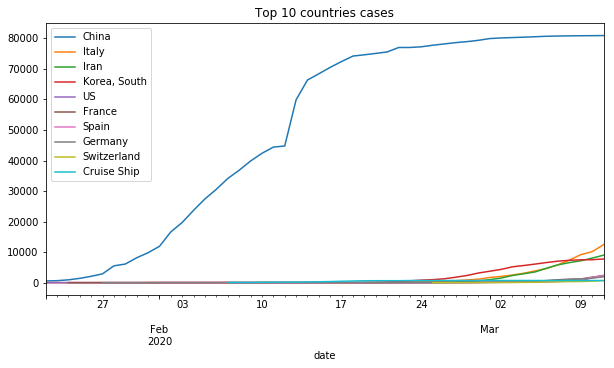

In [12]:
figure, ax = plt.subplots(1, 1, figsize = (10, 5))

for country in most_infected:
    ax0 = df[(df.CountryRegion == country) & (df.date >= start_date)].groupby('date').cum_cases.sum().plot(x='date', kind = 'line', legend=True, label=country, ax=ax)
g = ax0.set(title=f'Top {N} countries cases')

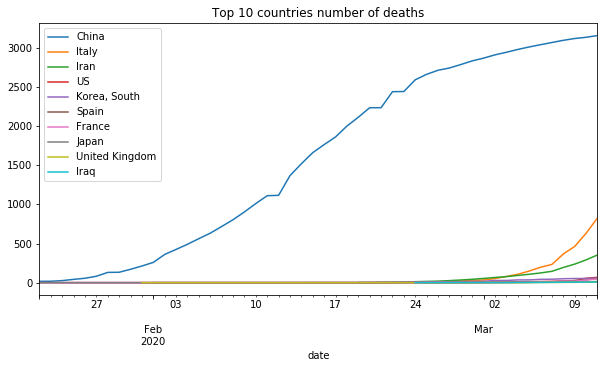

In [13]:
most_deaths = df.groupby('CountryRegion').new_deaths.sum().sort_values(ascending = False).head(N).index.tolist()[:]

figure, ax = plt.subplots(1, 1, figsize = (10, 5))
for country in most_deaths:
    ax0 = df[(df.CountryRegion == country) & (df.date >= start_date)].groupby('date').cum_deaths.sum().plot(x='date', kind = 'line', legend=True, label=country, ax=ax)

g = ax0.set(title = f'Top {N} countries number of deaths')

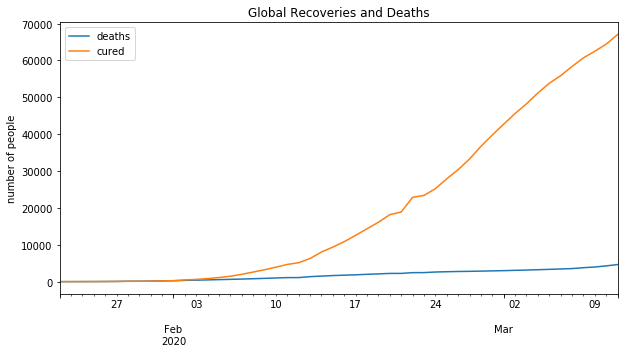

In [14]:
# check cured by deaths
figure, ax = plt.subplots(1, 1, figsize = (10, 5))

ax0 = df.groupby('date').cum_deaths.sum().plot(x='date', kind='line', ax=ax, legend = True, label = 'deaths')
ax1 = df.groupby('date').cum_cured.sum().plot(x='date', kind='line', ax=ax, legend = True, label = 'cured')

g = ax.set(title='Global Recoveries and Deaths', ylabel = 'number of people', xlabel = '')

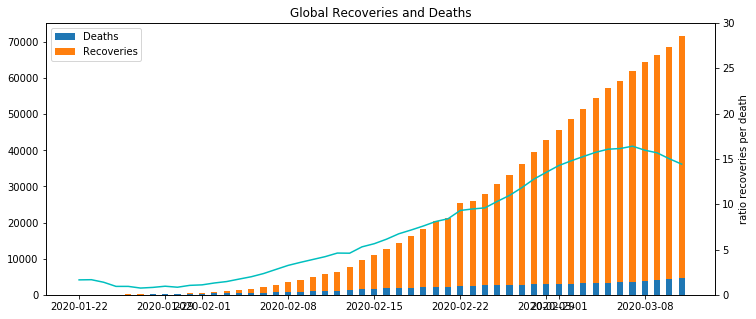

In [15]:
deaths = df.groupby('date').cum_deaths.sum()
recoveries = df.groupby('date').cum_cured.sum()
ratio = recoveries/deaths
w = 0.5

plt.figure(figsize = (12,5))
p1 = plt.bar(deaths.index, deaths, width=w)
p2 = plt.bar(recoveries.index, recoveries, width=w, bottom=deaths)
plt.legend((p1[0], p2[0]), ('Deaths', 'Recoveries'))

p3 = plt.twinx()
p3.plot(ratio.index, ratio, color='c')
p3.set_ylim(0, 30)
p3.set(title='Global Recoveries and Deaths')
g = p3.set_ylabel('ratio recoveries per death')


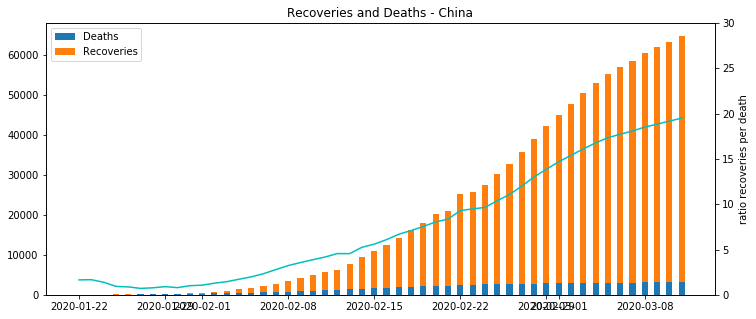

In [21]:
# statistics per country
country = 'China'

deaths = df[df.CountryRegion==country].groupby('date').cum_deaths.sum()
recoveries = df[df.CountryRegion==country].groupby('date').cum_cured.sum()
ratio = recoveries/deaths
w = 0.5

plt.figure(figsize = (12,5))
p1 = plt.bar(deaths.index, deaths, width=w)
p2 = plt.bar(recoveries.index, recoveries, width=w, bottom=deaths)
plt.legend((p1[0], p2[0]), ('Deaths', 'Recoveries'))

p3 = plt.twinx()
p3.plot(ratio.index, ratio, color='c')
p3.set_ylim(0, 30)
p3.set(title=f'Recoveries and Deaths - {country}')
g = p3.set_ylabel('ratio recoveries per death')


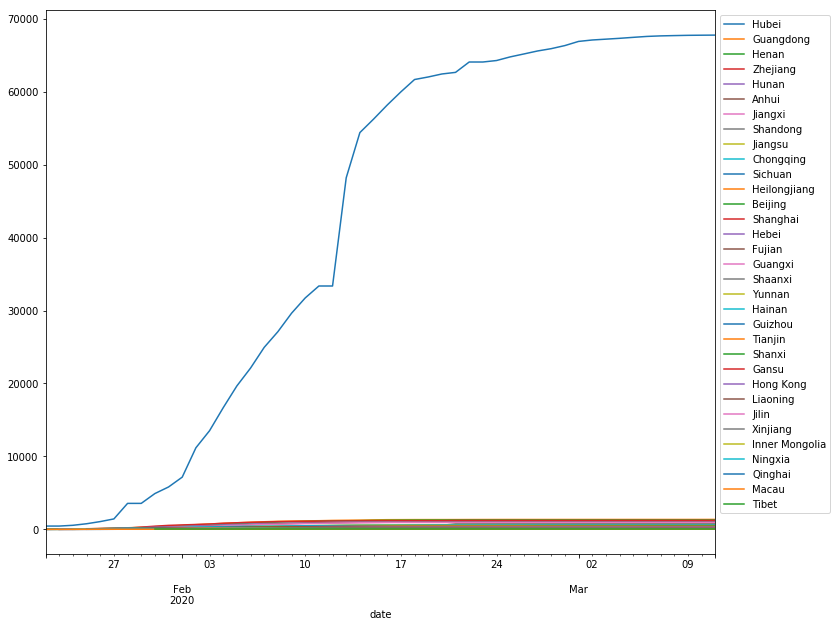

In [33]:
# statistics per country
country = 'China'
country_df = df[df.CountryRegion== country]
provinces = country_df.location.unique().tolist()


fig, ax = plt.subplots(1, 1, figsize = (12, 10))

for province in provinces:
    ax0 = country_df[country_df.location == province].plot(x='date', y='cum_cases', kind='line', ax=ax, label=province)


ax.legend(bbox_to_anchor=(1,1))

In [74]:
import plotly.express as px

#use density mapbox for plotting the data
fig = px.density_mapbox(df, lat='Lat', lon='Long', z="cum_cases", hover_name='location', radius=15, center=dict(lat=31, lon=113), zoom=1,
                        mapbox_style="carto-positron", title='COVID-19 Global cases')


fig.show()

In [79]:
fig = px.density_mapbox(df,
                        lat='Lat',
                        lon='Long',
                        z="cum_cured",
                        hover_name='location',
                        radius=15,
                        mapbox_style='carto-positron',
                        center=dict(lat=31, lon=113),
                        zoom=1,
                        title='COVID-19 Recoveries')
fig.show()

In [98]:
import plotly.graph_objects as go
country = 'Japan'
df_country = df[df.CountryRegion == country]

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_country.date, y=df_country.cum_cases, name="Cases",
                         line_color='dimgray'))
fig.add_trace(go.Scatter(x=df_country.date, y=df_country.cum_cured, name="Cured",
                         line_color='RoyalBlue'))

fig.add_trace(go.Scatter(x=df_country.date, y=df_country.cum_deaths, name="Deaths",
                         line_color='indianred'))

fig.update_layout(title_text=f'{country}: Cases, Cured and Deaths',
                  xaxis_rangeslider_visible=True)
fig.show()


# Data regression

### Logistic classifier

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [135]:
country = 'Korea, South'
X = df[df.CountryRegion == country].cum_cured.values






C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



array([ 0,  0,  3,  7, 16, 22, 30, 30, 41, 41], dtype=int64)

In [ ]:
X_pred = df[df.CountryRegion == 'Portugal'].cum_cases.values.reshape(-1,1)

log_Reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto', max_iter=10000)
log_Reg.fit(X, y.ravel())

y_pred = log_Reg.predict(X_pred)
y_pred